In [548]:
import pandas as pd
import numpy as np
import re

In [549]:
df = pd.read_csv("bds.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2436 entries, 0 to 2435
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ngay_dang            2435 non-null   object 
 1   loai_hinh            2435 non-null   object 
 2   dien_tich            2435 non-null   object 
 3   gia                  2435 non-null   object 
 4   giay_to_phap_ly      2127 non-null   object 
 5   so_phong_ngu         1425 non-null   float64
 6   so_phong_ve_sinh     1320 non-null   float64
 7   tinh_trang_noi_that  1400 non-null   object 
 8   link                 2436 non-null   object 
dtypes: float64(2), object(7)
memory usage: 171.4+ KB


In [550]:
df.rename(columns={
    'ngay_dang': 'Ngày đăng',
    'loai_hinh': 'Loại hình',
    'dien_tich': 'Diện tích (m²)',
    'gia': 'Giá (tỷ)',
    'giay_to_phap_ly': 'Giấy tờ pháp lý',
    'so_phong_ngu': 'Số phòng ngủ',
    'so_phong_ve_sinh': 'Số phòng vệ sinh',
    'tinh_trang_noi_that': 'Tình trạng nội thất',
    'link': 'Link'
}, inplace=True)
df.head()

,Ngày đăng,Loại hình,Diện tích (m²),Giá (tỷ),Giấy tờ pháp lý,Số phòng ngủ,Số phòng vệ sinh,Tình trạng nội thất,Link
0,09/10/2025,"Chung cư mini, căn hộ dịch vụ tại đường 1",49 m²,"1,55 tỷ",Sổ đỏ/ Sổ hồng,2.0,1.0,Cơ bản,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
1,21/10/2025,"Chung cư mini, căn hộ dịch vụ tại đường 10A",37 m²,"1,79 tỷ",Sổ đỏ/ Sổ hồng,2.0,NaN,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
2,21/10/2025,"Chung cư mini, căn hộ dịch vụ tại đường 10B",43 m²,"1,77 tỷ",Sổ đỏ/ Sổ hồng,2.0,NaN,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
3,21/10/2025,"Chung cư mini, căn hộ dịch vụ tại đường 13B",37 m²,"1,68 tỷ",đầy đủ.,2.0,NaN,đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
4,18/10/2025,"Chung cư mini, căn hộ dịch vụ tại đường An Dươ...",40 m²,"1,42 tỷ",Hợp đồng mua bán,1.0,1.0,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...


In [551]:
df = df.dropna(thresh=4)
df.shape

(2435, 9)

# Làm sạch dữ liệu

## Loại hình nhà

### Quy về các loại nhà: Nhà riêng, Nhà mặt phố, Chung cư, Shophouse, Biệt thự

In [552]:
def clean_property_type(value):
    text = str(value).lower().strip()

    if "nhà mặt phố" in text:
        return "Nhà mặt phố"
    
    elif "chung cư" in text or "căn hộ" in text or "apartment" in text:
        return "Chung cư"

    elif "shophouse" in text or "nhà phố thương mại" in text:
        return "Shophouse"

    elif "biệt thự" in text or "villa" in text:
        return "Biệt thự"

    elif "nhà riêng" in text:
        return "Nhà riêng"
    
    else:
        return "Khác"

In [553]:
df['Loại hình'] = df['Loại hình'].apply(clean_property_type)
df['Loại hình'].value_counts()

Loại hình
Nhà mặt phố    705
Shophouse      699
Nhà riêng      690
Chung cư       341
Name: count, dtype: int64

## Diện tích

### Đưa diện tích từ kiểu Object về Float

In [554]:
def convert_area(value):
    text = str(value).lower().replace("m²", "").replace("m2", "").strip()
    text = text.replace(",", ".")
    match = re.search(r'\d+(\.\d+)?', text)
    if not match:
        return np.nan
    
    num = float(match.group())
    return num

In [555]:
df["Diện tích (m²)"] = df["Diện tích (m²)"].apply(convert_area)
print(df["Diện tích (m²)"].value_counts())

Diện tích (m²)
50.0     127
100.0    111
75.0      71
40.0      70
60.0      69
        ... 
155.2      1
82.3       1
247.0      1
73.8       1
654.0      1
Name: count, Length: 427, dtype: int64


## Giá nhà

### - Đưa giá nhà từ kiểu Object về Float
### - Đồng nhất đơn vị là tỷ

In [556]:
def convert_price(value):
    text = str(value).lower().strip()
    text = text.replace(",", ".")
    match = re.search(r'\d+(\.\d+)?', text)
    if not match:
        return np.nan

    num = float(match.group())

    # Đổi triệu sang tỷ
    if "triệu" in text:
        num = num / 1000  
    elif "tỷ" in text or "ty" in text:
        num = num 
    else:
        num = num / 1000

    return round(num, 2) 

In [557]:
df["Giá (tỷ)"] = df["Giá (tỷ)"].apply(convert_price)
print(df["Giá (tỷ)"].value_counts())

Giá (tỷ)
32.00     21
18.00     20
13.50     20
12.50     18
36.00     18
          ..
106.32     1
32.07      1
78.90      1
0.38       1
0.06       1
Name: count, Length: 699, dtype: int64


## Giấy tờ pháp lý

In [558]:
def clean_text(text):
    if pd.isna(text):
        return np.nan
    text = str(text).lower()
    text = re.sub(r'[.,;!]', '', text)  # xóa dấu chấm, phẩy
    text = text.strip()
    return text

# Áp dụng làm sạch
df['Giấy tờ pháp lý'] = df['Giấy tờ pháp lý'].apply(clean_text)
df['Giấy tờ pháp lý']

0         sổ đỏ/ sổ hồng
1         sổ đỏ/ sổ hồng
2         sổ đỏ/ sổ hồng
3                 đầy đủ
4       hợp đồng mua bán
              ...       
2431                 NaN
2432    hợp đồng mua bán
2433    hợp đồng mua bán
2434      sổ đỏ/ sổ hồng
2435      sổ đỏ/ sổ hồng
Name: Giấy tờ pháp lý, Length: 2435, dtype: object

In [559]:
def categorize_legal(doc):
    if pd.isna(doc):
        return "Không rõ"
    if "sổ đỏ/ sổ hồng" in doc:
        return "Sổ đỏ/ Sổ hồng"
    elif "sổ đỏ" in doc:
        return "Sổ đỏ"
    elif "sổ hồng" in doc:
        return "Sổ hồng"
    elif "hợp đồng mua bán" in doc:
        return "Hợp đồng mua bán"
    elif "chờ sổ" in doc:
        return "Đang chờ sổ"
    elif "giấy phép xây dựng" in doc or "pccc" in doc:
        return "Đầy đủ pháp lý khác"
    else:
        return "Khác"  
df['Giấy tờ pháp lý'] = df['Giấy tờ pháp lý'].apply(categorize_legal)
df['Giấy tờ pháp lý'].value_counts()

Giấy tờ pháp lý
Sổ đỏ/ Sổ hồng         1569
Không rõ                308
Sổ đỏ                   232
Hợp đồng mua bán        182
Khác                    100
Sổ hồng                  22
Đang chờ sổ              18
Đầy đủ pháp lý khác       4
Name: count, dtype: int64

## Phòng ngủ

In [560]:
df["Số phòng ngủ"] = df["Số phòng ngủ"].round().astype("Int64")
mean_bed = round(df["Số phòng ngủ"].mean(skipna=True))
df["Số phòng ngủ"].fillna(mean_bed, inplace=True)

C:\Users\ACER\AppData\Local\Temp\ipykernel_22968\2842862189.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Số phòng ngủ"].fillna(mean_bed, inplace=True)


In [561]:
df["Số phòng ngủ"].value_counts().head()

Số phòng ngủ
6    1144
4     268
2     236
3     202
5     177
Name: count, dtype: Int64

## Phòng vệ sinh

In [562]:
df["Số phòng vệ sinh"] = df["Số phòng vệ sinh"].round().astype("Int64")
mean_wc  = round(df["Số phòng vệ sinh"].mean(skipna=True))
df["Số phòng vệ sinh"].fillna(mean_wc , inplace=True)

C:\Users\ACER\AppData\Local\Temp\ipykernel_22968\3885926590.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Số phòng vệ sinh"].fillna(mean_wc , inplace=True)


In [563]:
df["Số phòng vệ sinh"].value_counts().head()

Số phòng vệ sinh
6    1192
4     280
1     253
5     168
3     160
Name: count, dtype: Int64

## Tình trạng nội thất

In [564]:
df["Tình trạng nội thất"].value_counts()

Tình trạng nội thất
Đầy đủ                                                    776
Cơ bản                                                    346
Không nội thất                                            129
Full nội thất                                              32
đầy đủ                                                     23
                                                         ... 
cao cấp Luxuryk khách mua có thể cho thuê hoặc ở luôn.      1
Bàn giao hoàn thiện mặt ngoài, thô bên trong                1
Hoàn thiện mặt ngoài, bên trong bàn giao thô                1
nhập khẩu châu Âu đẳng cấp.                                 1
Bàn giao thô.                                               1
Name: count, Length: 71, dtype: int64

In [565]:
def clean_interior(value):
    if pd.isna(value):
        return "Không rõ"
    
    text = str(value).lower().strip()

    if "đầy đủ" in text or "full" in text or "đủ nội thất" in text or "full đồ" in text:
        return "Đầy đủ"
    elif "cơ bản" in text:
        return "Cơ bản"
    elif "không" in text and "nội thất" in text:
        return "Không nội thất"
    elif "thô" in text or "bàn giao thô" in text:
        return "Bàn giao thô"
    else:
        return "Khác"
    

In [566]:
df["Tình trạng nội thất"] = df["Tình trạng nội thất"].apply(clean_interior)
df["Tình trạng nội thất"].value_counts()

Tình trạng nội thất
Không rõ          1035
Đầy đủ             845
Cơ bản             359
Không nội thất     130
Khác                59
Bàn giao thô         7
Name: count, dtype: int64

In [567]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2435 entries, 0 to 2435
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ngày đăng            2435 non-null   object 
 1   Loại hình            2435 non-null   object 
 2   Diện tích (m²)       2435 non-null   float64
 3   Giá (tỷ)             2112 non-null   float64
 4   Giấy tờ pháp lý      2435 non-null   object 
 5   Số phòng ngủ         2435 non-null   Int64  
 6   Số phòng vệ sinh     2435 non-null   Int64  
 7   Tình trạng nội thất  2435 non-null   object 
 8   Link                 2435 non-null   object 
dtypes: Int64(2), float64(2), object(5)
memory usage: 195.0+ KB


# Xử lý ngoại lai

In [568]:
import matplotlib.pyplot as plt
import seaborn as sns

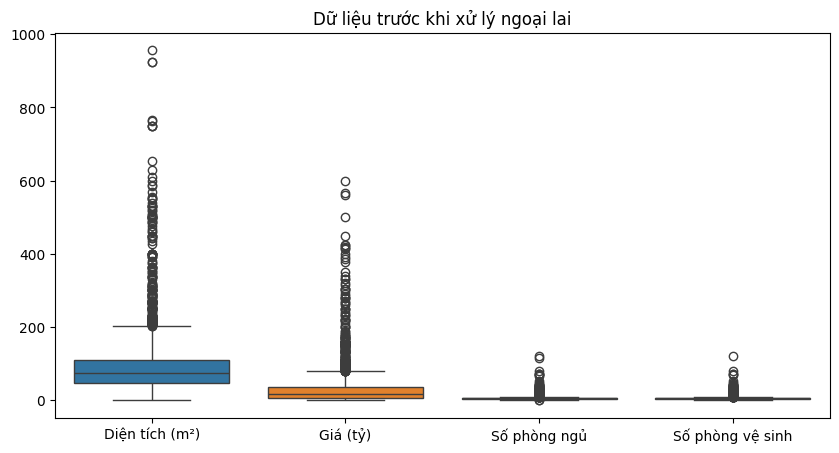

In [569]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df.select_dtypes(include=["float64", "int64"]))
plt.title("Dữ liệu trước khi xử lý ngoại lai")
plt.show()

In [570]:
def handle_outliers(df, factor=1.5):
    df_clean = df.copy()
    
    # Chỉ xử lý các cột dạng số
    numeric_cols = df_clean.select_dtypes(include=["float64", "int64"]).columns
    
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean


In [571]:
print("Trước khi xử lý:", df.shape)
df_clean = handle_outliers(df)
print("Sau khi xử lý:", df_clean.shape)


Trước khi xử lý: (2435, 9)
Sau khi xử lý: (1691, 9)


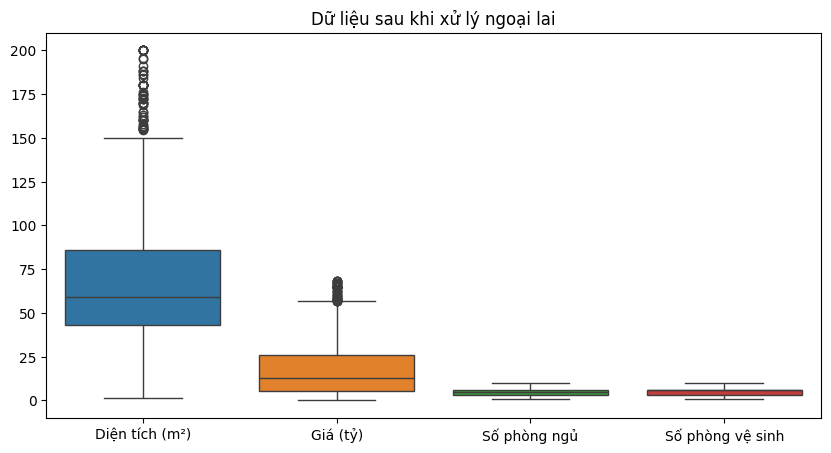

In [572]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_clean.select_dtypes(include=["float64", "int64"]))
plt.title("Dữ liệu sau khi xử lý ngoại lai")
plt.show()


In [573]:
df_clean.to_csv("bds_clean.csv", index=False, encoding="utf-8-sig")


# Chuẩn hóa dữ liệu

In [574]:
from sklearn.preprocessing import MinMaxScaler

cols_scale = ["Diện tích (m²)", "Số phòng ngủ", "Số phòng vệ sinh"]
scaler = MinMaxScaler()
df_scaled = df_clean.copy()
df_scaled[cols_scale] = scaler.fit_transform(df_clean[cols_scale])

df_scaled.head()


,Ngày đăng,Loại hình,Diện tích (m²),Giá (tỷ),Giấy tờ pháp lý,Số phòng ngủ,Số phòng vệ sinh,Tình trạng nội thất,Link
0,09/10/2025,Chung cư,0.239869,1.55,Sổ đỏ/ Sổ hồng,0.111111,0.000000,Cơ bản,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
1,21/10/2025,Chung cư,0.179461,1.79,Sổ đỏ/ Sổ hồng,0.111111,0.555556,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
2,21/10/2025,Chung cư,0.209665,1.77,Sổ đỏ/ Sổ hồng,0.111111,0.555556,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
3,21/10/2025,Chung cư,0.179461,1.68,Khác,0.111111,0.555556,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
4,18/10/2025,Chung cư,0.194563,1.42,Hợp đồng mua bán,0.000000,0.000000,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...


In [575]:
import matplotlib.pyplot as plt
import seaborn as sns


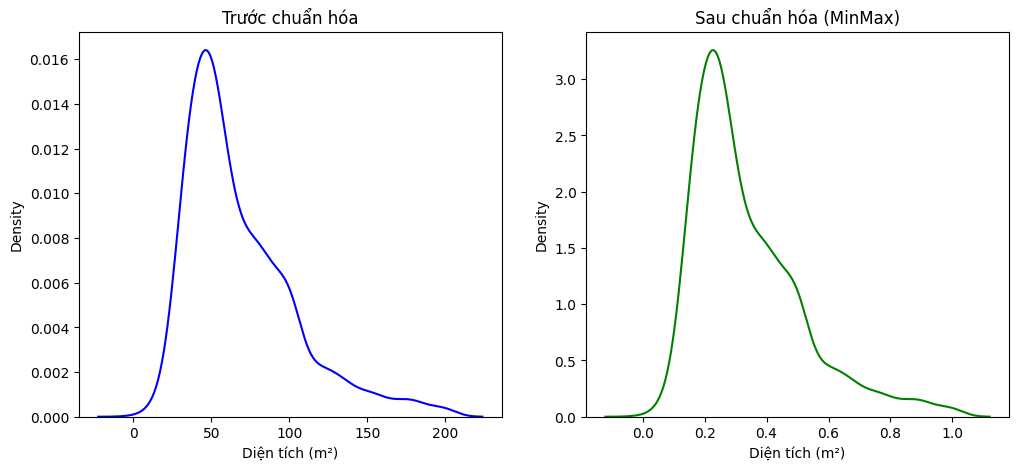

In [576]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(df_clean["Diện tích (m²)"], ax=axes[0], color="blue")
axes[0].set_title("Trước chuẩn hóa")
sns.kdeplot(df_scaled["Diện tích (m²)"], ax=axes[1], color="green")
axes[1].set_title("Sau chuẩn hóa (MinMax)")
plt.show()

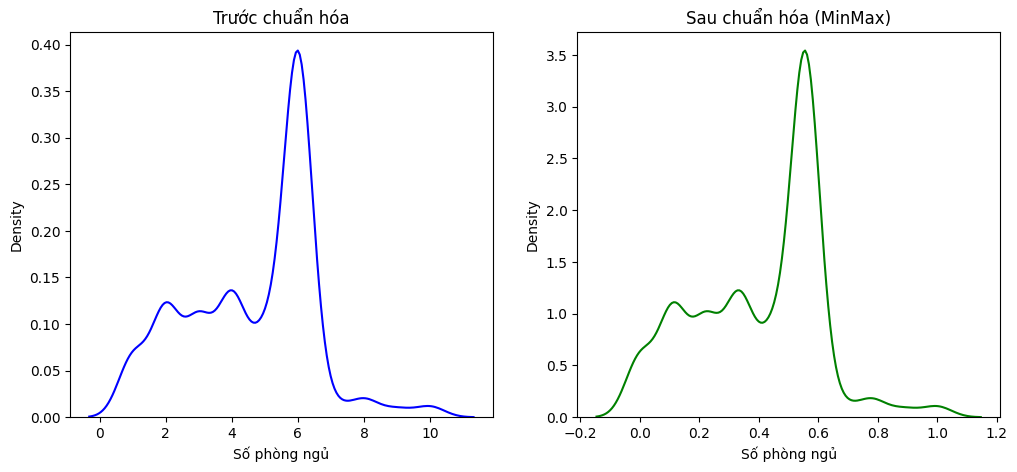

In [577]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(df_clean["Số phòng ngủ"], ax=axes[0], color="blue")
axes[0].set_title("Trước chuẩn hóa")
sns.kdeplot(df_scaled["Số phòng ngủ"], ax=axes[1], color="green")
axes[1].set_title("Sau chuẩn hóa (MinMax)")
plt.show()

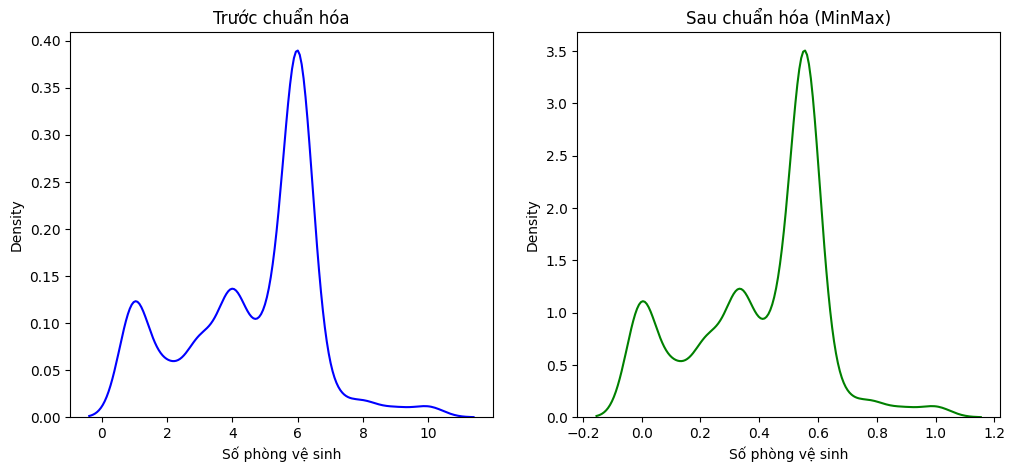

In [578]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(df_clean["Số phòng vệ sinh"], ax=axes[0], color="blue")
axes[0].set_title("Trước chuẩn hóa")
sns.kdeplot(df_scaled["Số phòng vệ sinh"], ax=axes[1], color="green")
axes[1].set_title("Sau chuẩn hóa (MinMax)")
plt.show()

# Xây dựng mô hình dự đoán

In [579]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [580]:
le_loai = LabelEncoder()
le_phaply = LabelEncoder()
le_noithat = LabelEncoder()

df["Loại hình"] = df["Loại hình"].astype(str)
df["Giấy tờ pháp lý"] = df["Giấy tờ pháp lý"].astype(str)
df["Tình trạng nội thất"] = df["Tình trạng nội thất"].astype(str)

df["Loại hình (encoded)"] = le_loai.fit_transform(df["Loại hình"])
df["Giấy tờ pháp lý (encoded)"] = le_phaply.fit_transform(df["Giấy tờ pháp lý"])
df["Tình trạng nội thất (encoded)"] = le_noithat.fit_transform(df["Tình trạng nội thất"])


In [581]:
df_scaled

,Ngày đăng,Loại hình,Diện tích (m²),Giá (tỷ),Giấy tờ pháp lý,Số phòng ngủ,Số phòng vệ sinh,Tình trạng nội thất,Link
0,09/10/2025,Chung cư,0.239869,1.55,Sổ đỏ/ Sổ hồng,0.111111,0.000000,Cơ bản,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
1,21/10/2025,Chung cư,0.179461,1.79,Sổ đỏ/ Sổ hồng,0.111111,0.555556,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
2,21/10/2025,Chung cư,0.209665,1.77,Sổ đỏ/ Sổ hồng,0.111111,0.555556,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
3,21/10/2025,Chung cư,0.179461,1.68,Khác,0.111111,0.555556,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
4,18/10/2025,Chung cư,0.194563,1.42,Hợp đồng mua bán,0.000000,0.000000,Đầy đủ,https://batdongsan.com.vn/ban-can-ho-chung-cu-...
...,...,...,...,...,...,...,...,...,...
2421,22/10/2025,Shophouse,0.194563,3.00,Hợp đồng mua bán,0.555556,0.222222,Không nội thất,https://batdongsan.com.vn/ban-shophouse-nha-ph...
2422,23/10/2025,Shophouse,0.364712,0.17,Sổ đỏ/ Sổ hồng,0.555556,0.555556,Không nội thất,https://batdongsan.com.vn/ban-shophouse-nha-ph...
2423,25/10/2025,Shophouse,0.370753,10.00,Sổ đỏ/ Sổ hồng,0.555556,0.555556,Không rõ,https://batdongsan.com.vn/ban-shophouse-nha-ph...
2425,23/10/2025,Shophouse,0.637553,28.80,Sổ đỏ/ Sổ hồng,0.555556,0.555556,Không rõ,https://batdongsan.com.vn/ban-shophouse-nha-ph...


In [582]:
cols_for_model = [
    "Loại hình (encoded)",
    "Diện tích (m²)",
    "Giấy tờ pháp lý (encoded)",
    "Số phòng ngủ",
    "Số phòng vệ sinh",
    "Tình trạng nội thất (encoded)"
]
X = df_scaled[cols_for_model]
Y = df_scaled['Giá (tỷ)']

KeyError: "['Loại hình (encoded)', 'Giấy tờ pháp lý (encoded)', 'Tình trạng nội thất (encoded)'] not in index"

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2 = model.score(X_test, Y_test)
print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

MAE: 9.225 | RMSE: 12.806 | R²: 0.371


In [ ]:
import gradio as gr
import joblib
import numpy as np

In [ ]:
joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le_loai, "le_loai.pkl")
joblib.dump(le_phaply, "le_phaply.pkl")
joblib.dump(le_noithat, "le_noithat.pkl")

['le_noithat.pkl']

In [ ]:
model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")
le_loai = joblib.load("le_loai.pkl")
le_phaply = joblib.load("le_phaply.pkl")
le_noithat = joblib.load("le_noithat.pkl")


In [ ]:
def predict(loai_hinh, dien_tich, phap_ly, phong_ngu, phong_vs, noi_that):
    # Encode input
    loai_enc = le_loai.transform([loai_hinh])[0]
    phaply_enc = le_phaply.transform([phap_ly])[0]
    noithat_enc = le_noithat.transform([noi_that])[0]
    
    # Scale continuous inputs only
    scaled_continuous = scaler.transform([[dien_tich, phong_ngu, phong_vs]])[0]
    dien_tich_s, phong_ngu_s, phong_vs_s = scaled_continuous
    
    # Combine features
    features = np.array([[loai_enc, dien_tich_s, phaply_enc, phong_ngu_s, phong_vs_s, noithat_enc]])
    
    predicted = model.predict(features)[0]
    return f"💰 Dự đoán giá: {predicted:.2f} tỷ đồng"

In [ ]:
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Dropdown(["Nhà riêng", "Nhà mặt phố", "Chung cư", "Biệt thự", "Shophouse"], label="Loại hình"),
        gr.Number(label="Diện tích (m²)", value=80),
        gr.Dropdown(["Sổ đỏ", "Sổ hồng", "Hợp đồng mua bán", "Đang chờ sổ", "Đầy đủ pháp lý khác"], label="Giấy tờ pháp lý"),
        gr.Slider(0, 10, 2, step=1, label="Số phòng ngủ"),
        gr.Slider(0, 10, 1, step=1, label="Số phòng vệ sinh"),
        gr.Dropdown(["Đầy đủ", "Cơ bản", "Không nội thất", "Bàn giao thô"], label="Tình trạng nội thất"),
    ],
    outputs="text",
    title="🏠 Dự đoán giá nhà bất động sản",
    description="Nhập thông tin chi tiết để dự đoán giá nhà (đơn vị: tỷ đồng).",
    theme="gradio/soft"
)

iface.launch(inline=True)

* Running on local URL:  http://127.0.0.1:7875
* To create a public link, set `share=True` in `launch()`.


d:\code\python\KHDL\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Traceback (most recent call last):
  File "d:\code\python\KHDL\.venv\Lib\site-packages\gradio\queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    )
    ^
  File "d:\code\python\KHDL\.venv\Lib\site-packages\gradio\route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<11 lines>...
    )
    ^
  File "d:\code\python\KHDL\.venv\Lib\site-packages\gradio\blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^
  File "d:\code\python\KHDL\.venv\Lib\site-packages\gradio\blocks.py", line 1623, in call_func